# Fusion Hub Data Quick-Start

#### <span style="color:red">This is an modified version (by Cruickshank) of the quickstart code.</span>
#### Modifications made:
1. Location and time variables are modified.
2. Some code cells have been removed.
3. Some code cells have been put into functions.
4. Stacking of image tiles has been looped in order to handle smaller chunks of data.
5. HRRR data is fetched.
6. CATD is calculated.

----------------------------------------------

This notebook demonstrates the process of:
* Searching a collection to intersect a point location between a start data and end date
* Converting the search result to an `xarray` DataArray
* Subsetting the DataArray to a geometry
* Plotting the time series in a grid
* Extracting data from a point location
* Reducing the data within a geometry
* Downloading a file based on valid data percentage
* Downloading multiple files
* Removing data entries based on some condition
* Creating matplotlib animations

In [1]:
import json
import requests
import pystac
from pystac_client import Client
from pprint import pprint

from botocore.exceptions import ClientError
from shapely.geometry import box, mapping, Point, Polygon
from pyproj.crs import CRS
import pandas as pd
import geopandas as gpd

import xarray as xr
import rioxarray as rxr
import rasterio as rio

from matplotlib import pyplot as plt
import numpy as np

from FH_Hydrosat import FH_StackedDataset
from FH_Hydrosat import FH_Hydrosat

import os
import base64
from datetime import datetime

/var/folders/zs/pstrmbpn6t75t6hdl9_v8_8w0000gn/T/ipykernel_11735/2811197353.py:11: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


If you see `ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed`, do not fret, and proceed.

### Logging in to the Fusion database.

This next cell opens a file `creds.json` which you will need to create in the same directory 
as the notebook. The format of the file should be:

{
"username":"your_username",
"password":"your_password"
}

and you have updated with your username and password. 

In [2]:

with open('creds.json') as f:
    creds = json.loads(f.read())

# Endecode the `username:password` combination 
# and use it to authorize access to the STAC API given by the `cat_url` 
# endpoint.userpass = f"{creds['username']}:{creds['password']}"
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

### Search for available Fusion coverage for point location.
We'll search for data in the `starfm_predictions_modis_landsat` and `pydms_sharpened_landsat` collections which intersect a point location between a start date and an end date and print out the number of items. 

In [161]:
# Specifiy location and time frame for image download.
site_name = 'ames'
lat = 42.0
lon = -93.7

geom = {'type': 'Point', 'coordinates': [lon, lat]} 

#collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat"]
collections = ["starfm_predictions_modis_landsat"]
start_date = "2020-04-01T00:00:00Z"
end_date = "2020-07-31T00:00:00Z"

search = catalog.search(
    collections = collections,
    intersects = geom,
    datetime = [start_date, end_date],
    max_items = 500
)

# items = list(search.items()) # for pystac-client >= 0.4.0
items = list(search.get_all_items()) # for pystac-client < 0.4.0
items.reverse() # make the results ascending in time

print ("Number of fusion tiles available fusion tiles {}:".format(len(items)))
print (items)

Number of fusion tiles available fusion tiles 103:
[<Item id=15TVG_pred_20200406_from_20200405_using_MODIS_Landsat>, <Item id=15TVG_pred_20200407_from_20200405_using_MODIS_Landsat>, <Item id=15TVG_pred_20200408_from_20200405_using_MODIS_Landsat>, <Item id=15TVG_pred_20200409_from_20200405_using_MODIS_Landsat>, <Item id=15TVG_pred_20200410_from_20200405_using_MODIS_Landsat>, <Item id=15TVG_pred_20200411_from_20200405_using_MODIS_Landsat>, <Item id=15TVG_pred_20200413_from_20200412_using_MODIS_Landsat>, <Item id=15TVG_pred_20200414_from_20200412_using_MODIS_Landsat>, <Item id=15TVG_pred_20200415_from_20200412_using_MODIS_Landsat>, <Item id=15TVG_pred_20200416_from_20200412_using_MODIS_Landsat>, <Item id=15TVG_pred_20200417_from_20200412_using_MODIS_Landsat>, <Item id=15TVG_pred_20200418_from_20200412_using_MODIS_Landsat>, <Item id=15TVG_pred_20200419_from_20200412_using_MODIS_Landsat>, <Item id=15TVG_pred_20200420_from_20200412_using_MODIS_Landsat>, <Item id=15TVG_pred_20200422_from_2020

### Does the data returned for the point cross multiple tiles?
This next cell will determine if the data returned covers more than a single MGRS tile. If there is, choose one of the tiles to subset the list of returned items.

In [94]:
mgrs_tiles = []
for i in items:
    for l in i.to_dict()['links']:
        if 'element84' in l['href']:
            mgrs_tiles.append(l['href'].split(r'/')[-1].split('_')[1])
            
print(f'Number of tiles in query: {len(set(mgrs_tiles))}, {set(mgrs_tiles)}')

# if there is more than one tile, uncomment and execute this 
# next line to choose the MGRS tile you are interested in
# items = [i for i in items if mgrs_tiles[0] in i.id]

Number of tiles in query: 1, {'15TVG'}


### Create two functions to create AOI polygon for clipping to define a smaller dataarry.
The `DataArray` is quite large if we try to access all of the data. For ease of computation, we'll subset the `DataArray` by a polygon, which will be generated by creating a rectangular buffer around the point location by 1km on either side.

In [162]:
def create_clip_polygon(geom, ds):
    """
    Create a polygon that we will use for clipping the big dataset.

    Parameters:
    ----------
    geom: dict
        Dictionary of lat and lon of center point of AOI.

    Returns:
    -------
    poly: dataframe
        Contains geometry of a square to be used for clipping.
    """
    # Using the point coords defined earlier, create a df with the point geometry.
    p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])
    point_df = gpd.GeoDataFrame({'geometry':[p_geom]}, crs=CRS.from_epsg(4326))

    # Define a buffer size (for each side of the point.
    # Reproject the point df and create the new polygon.
    raster_crs = CRS.from_wkt(ds.spatial_ref.crs_wkt)
    buffer_dist = 1000 # 1km in local UTM zone

    # create a square buffer
    poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) 

    return(poly_df)

In [163]:
def clip(poly_df, chunk_ds):
    ''' 
    Clip the big stacked dataset.

    Parameters: 
    -----------
    poly_df: geodataframe

    Returns:
    -------
    ds_clip: dataset
        This is our clipped, smaller dataset.
    '''
    # Want to create a new StackedDataset object using a smaller clipped
    # version of the big whole image dataset.
    clipped = FH_StackedDataset(chunk_ds.rio.clip(poly_df.geometry))
    clip_ds = clipped.ds  #*************** what is this?
    
    return(clip_ds)

Now we'll pass the first 25 items to the `FH_Hydrosat` class and stack the items into an `xarray` `DataArray`. We'll print out the DataArray to get a summary of its contents.

In [6]:
# ********** DONT RUN THIS CELL. ************** #
# ********** USE CELL BELOW INSTEAD ********** #

# We dont want to load all 180 days of tiles because they are too large.
# Instead, we'll work with smaller chunks, load them, and then clip
# them down to size and concat the dataarrays.

chunk_size = 10 # days.
lst_das = []
stacked_lst_da = []
i = 0
j = 0

for i in range(-1, len(items)-1, 10):
    j = i + 10

    print ("Processing i:{} , j:{} chunks.".format(i+1, j))

    # Load 10 images at a time.
    res = FH_Hydrosat(items[i+1:j])
    stacked_res = res.stack()
    stacked_res.ds.sortby('time')

    # Sort the dataset by time.
    chunk_ds = stacked_res.ds.sortby('time')

    # Create a polygon that we can clip to.
    # Only need to do it once but we do need the
    # dataset to get the crs.
    if i == -1:
        clip_poly_df = create_clip_polygon(geom, stacked_res.ds)

    # Clip the dataset.
    clip_ds = clip(clip_poly_df, chunk_ds)

    # Add DataArray to list for concatenation
    lst_das.append(clip_ds)
    
    i = j + 1

stacked_lst_da = xr.concat(lst_das, dim="date") 

# Once these are concated, we end up with an extra dim
# called 'date'.  We dont need this.  We just need 'time.
# We'll squeeze it off otherwise it will cause problems later.
# stacked_lst_da = stacked_lst_da.squeeze()
stacked_lst_da

Processing i:0 , j:9 chunks.
Processing i:10 , j:19 chunks.
Processing i:20 , j:29 chunks.


<xarray.DataArray (date: 3, time: 25, band: 1, y: 100, x: 100)>
dask.array<concatenate, shape=(3, 25, 1, 100, 100), dtype=float32, chunksize=(1, 2, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.41e+05 4.41e+05 4.411e+05 ... 4.43e+05 4.43e+05
  * y            (y) float64 4.651e+06 4.651e+06 ... 4.649e+06 4.649e+06
  * time         (time) object 2020-07-02T00:00:00+00:00 ... 2020-07-31T00:00...
    spatial_ref  int64 0
Dimensions without coordinates: date
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          nan

In [164]:
from FH_Hydrosat import FH_Hydrosat

print ("Start 1:{}".format(datetime.now()))
res = FH_Hydrosat(items[:156])
print ("Start 2:{}".format(datetime.now()))
stacked_res = res.stack()
print ("Start 3:{}".format(datetime.now()))
stacked_res.ds.sortby('time')
print ("Start 4:{}".format(datetime.now()))

# Sort the dataset by time.
ds = stacked_res.ds.sortby('time')
print ("Start 5:{}".format(datetime.now()))

# Create polygon AOI.
clip_poly_df = create_clip_polygon(geom, ds)
# Use AOI to clip raster dwon to size.
stacked_lst_da = clip(clip_poly_df, ds)

stacked_lst_da

Start 1:2023-04-17 10:23:56.025025
Start 2:2023-04-17 10:23:56.107075
Start 3:2023-04-17 10:39:33.031779
Start 4:2023-04-17 10:39:33.039781
Start 5:2023-04-17 10:39:33.042196


<xarray.DataArray (time: 103, band: 1, y: 100, x: 100)>
dask.array<getitem, shape=(103, 1, 100, 100), dtype=float32, chunksize=(1, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.41e+05 4.41e+05 4.411e+05 ... 4.43e+05 4.43e+05
  * y            (y) float64 4.651e+06 4.651e+06 ... 4.649e+06 4.649e+06
  * time         (time) object 2020-04-06T00:00:00+00:00 ... 2020-07-31T00:00...
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          nan

### Plot the polygon on a Folium map so we can see where we are extracting the data

In [ ]:
import folium 

# Use WGS 84 (epsg:4326) as the geographic coordinate system
df = gpd.GeoDataFrame(poly_df.to_crs(epsg=4326))

m = folium.Map(location=[p_geom.y, p_geom.x], zoom_start=15, tiles='CartoDB positron', control_scale=True)

# ---------------------------------
# Use satellite image for base map.
tile = folium.TileLayer(
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr = 'Esri',
    name = 'Esri Satellite',
    overlay = False,
    control = True
    ).add_to(m)
# ---------------------------------

# add the polygon and centroid
for _, r in df.iterrows():
    # Without simplifying the representation of each polygon,
    # the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    sim_geo = r[0].simplify(tolerance=0.001)
    geo_j = gpd.GeoSeries(sim_geo).to_json()
    geo_j = folium.GeoJson(data=geo_j,
                    style_function=lambda x: {'fillColor': 'orange'})

    geo_j.add_to(m)
        
    lat = sim_geo.centroid.y
    lon = sim_geo.centroid.x
    folium.Marker(location=[lat, lon]).add_to(m)
    
m

### Plot the clipped dataarray contents on a facet grid according to the `time` dimension.

ERROR 1: Request for 60428441-61857221 failed with response_code=0
ERROR 1: Request for 60470254-61899967 failed with response_code=0
ERROR 1: Request for 60421123-61850463 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 60801854-62245993 failed with response_code=0
ERROR 1: Request for 63188261-64686747 failed with response_code=0
ERROR 1: Request for 63375493-64883909 failed with response_code=0
ERROR 1: _TIFFPartialReadStripArray:Cannot read offset/size for strile around ~184
ERROR 1: _TIFFPartialReadStripArray:Cannot read offset/size for strile around ~184
ERROR 1: _TIFFPartialReadStripArray:Cannot read offset/size for strile around ~184


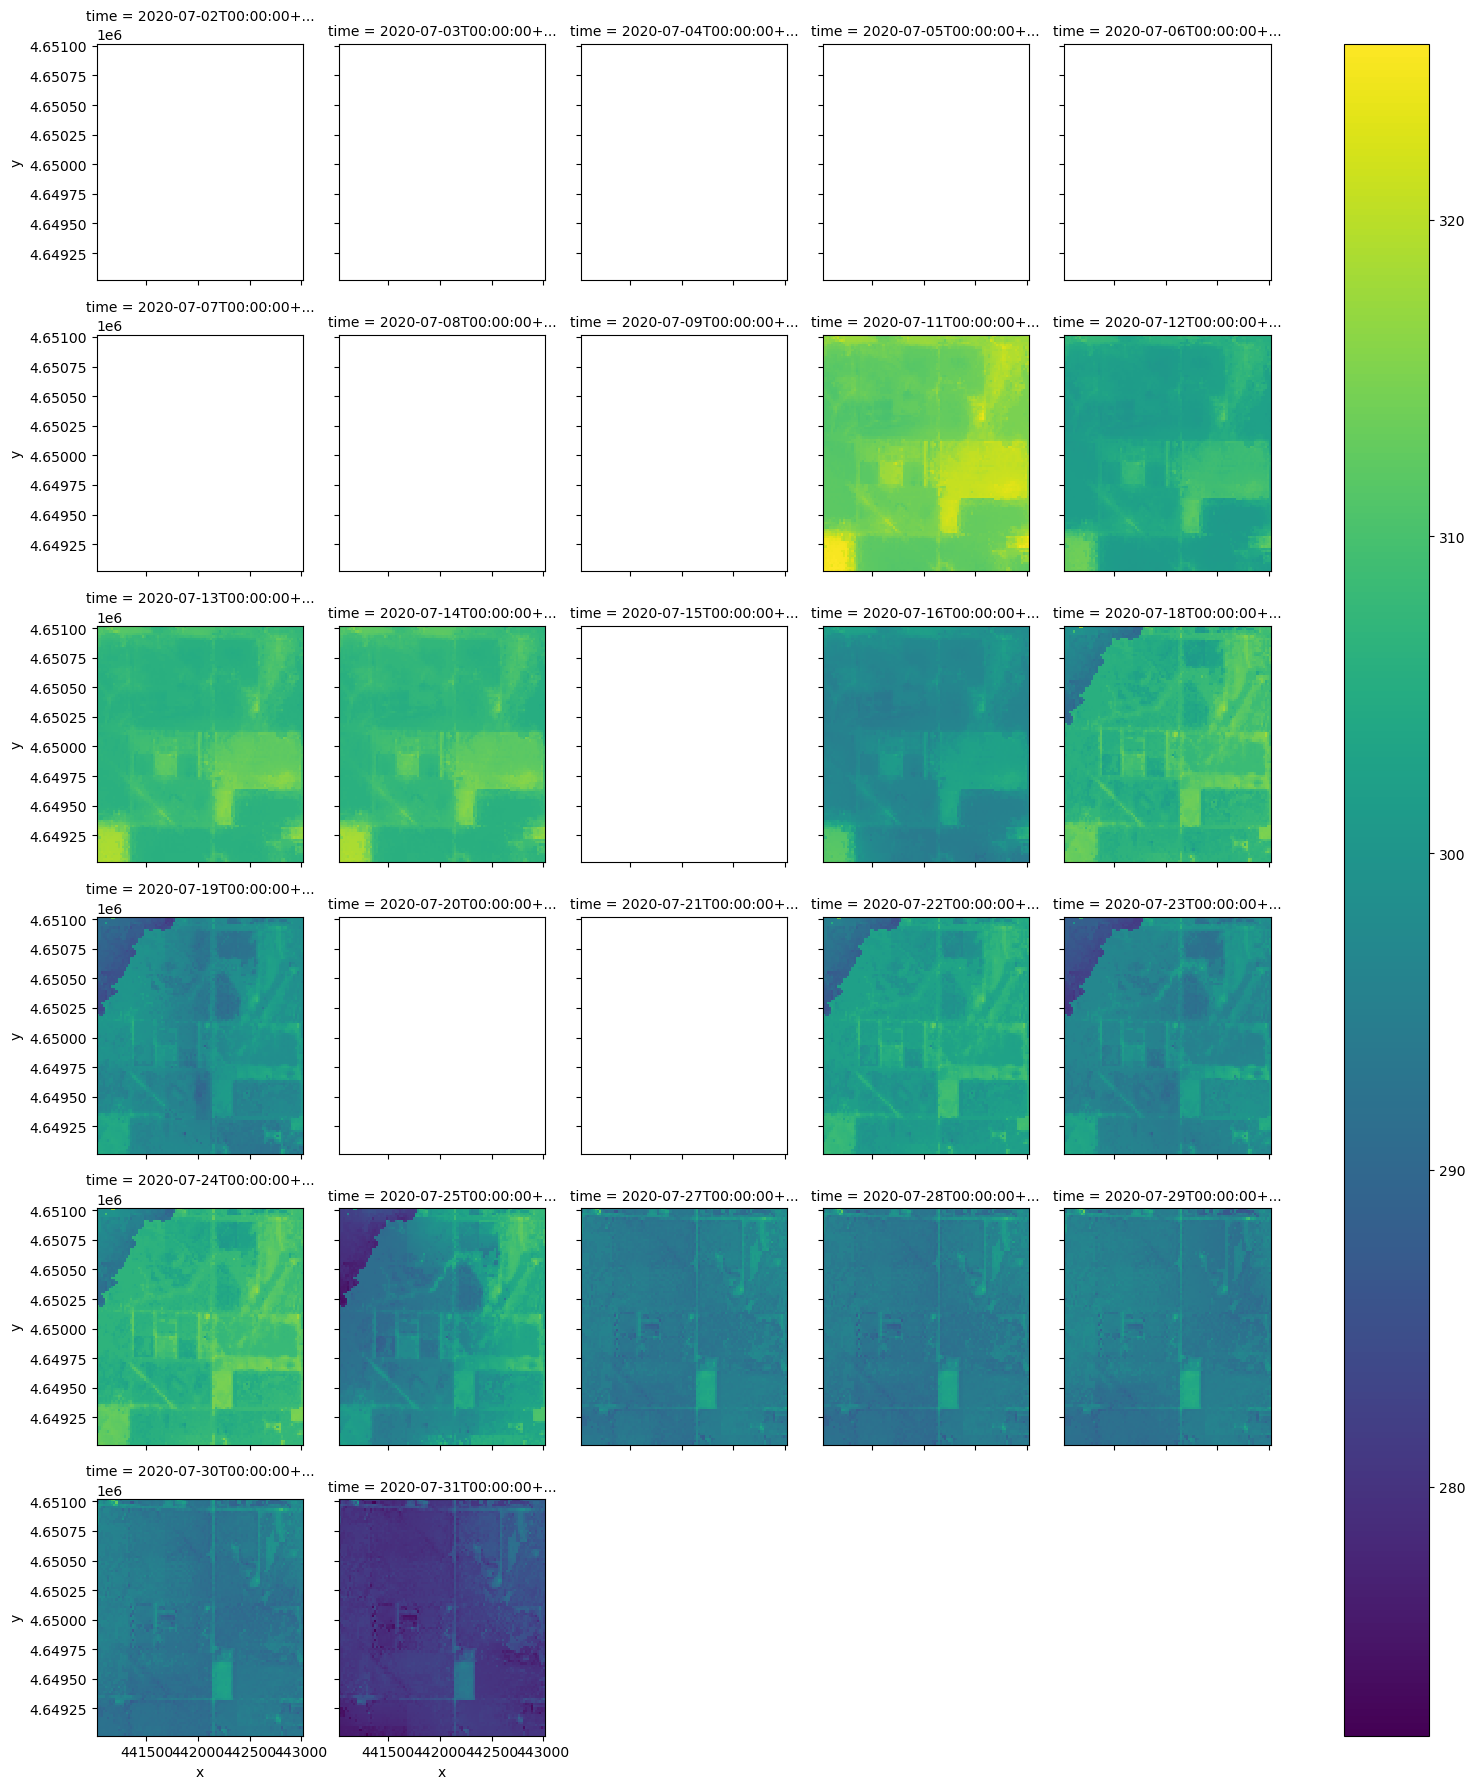

In [36]:
stacked_lst_da.plot(x='x', y='y', col='time', col_wrap=5)


### Plot the tiles agin with the point location and then a time series for the location.


With the same `DataArray`, we can extract the pixel values which intersect a point location. Let's use the same point location we used to search the STAC catalog and plot it.

ERROR 1: Request for 58699279-60072851 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 60944884-62392849 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 58602449-59981887 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 61290552-62736038 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 59828210-61239651 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 62125091-63589587 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 61287452-62736107 failed with response_code=0
ERROR 1: Request for 346275

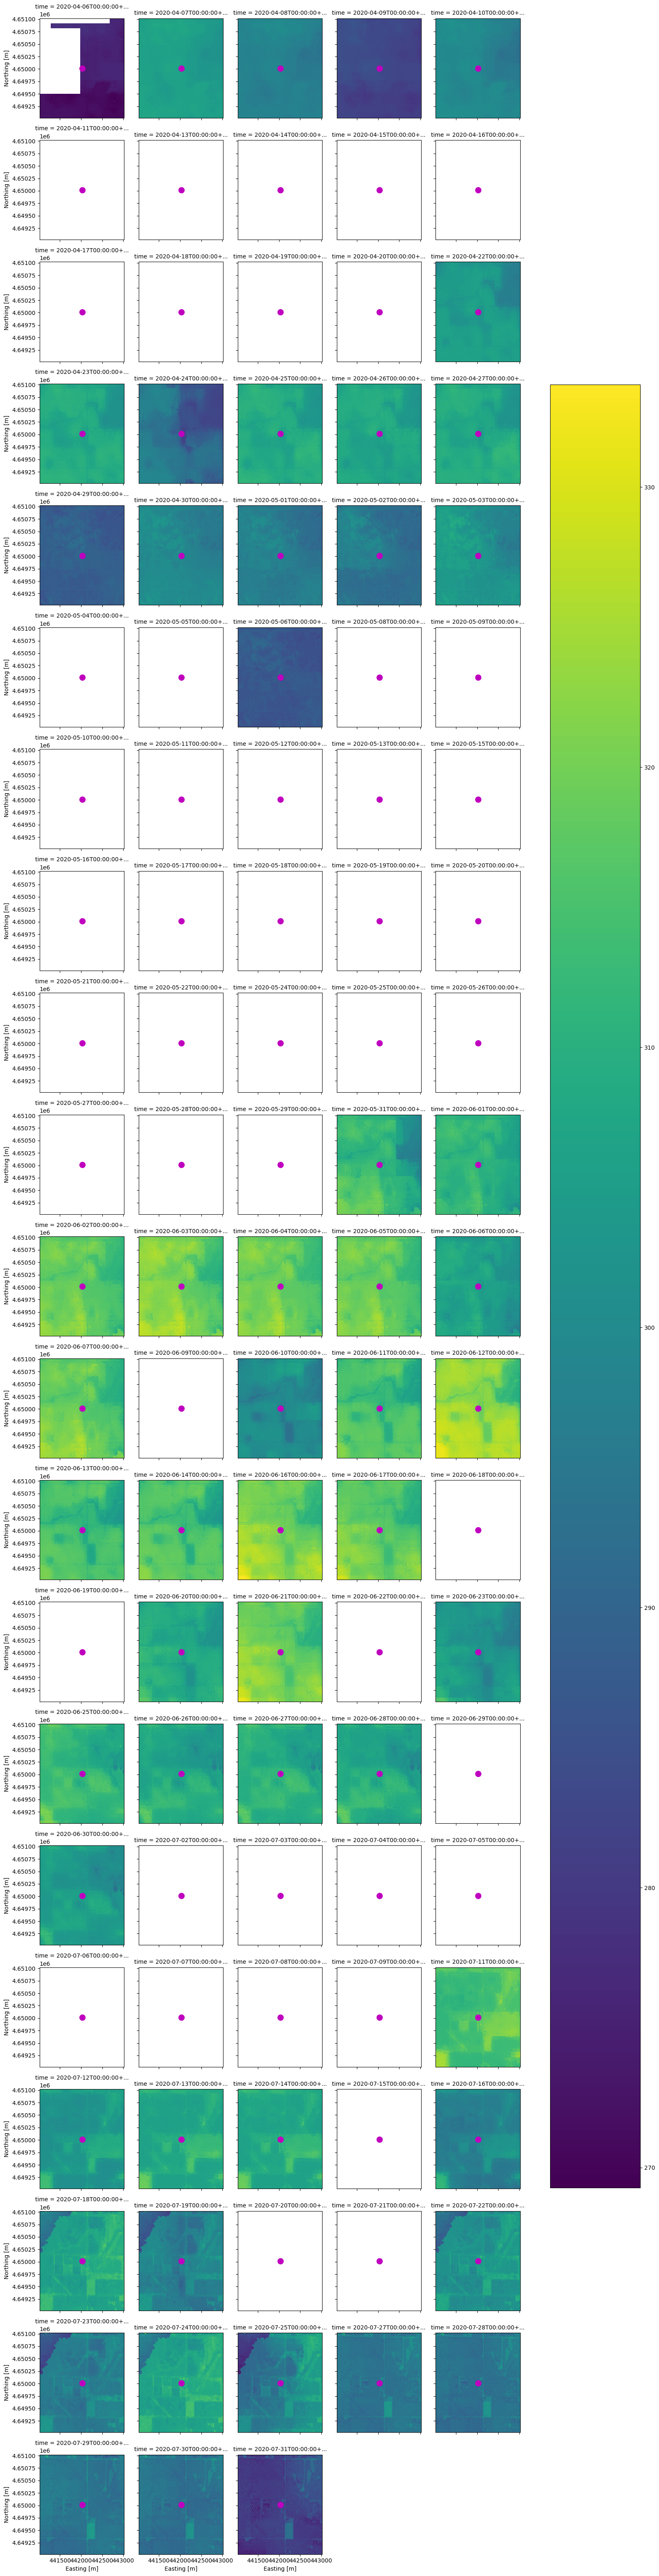

ERROR 1: Request for 60421123-61850463 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 63157223-64654933 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 59828210-61239651 failed with response_code=0
ERROR 1: Request for 61340711-62788845 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 61116143-62554192 failed with response_code=0
ERROR 1: Request for 61290552-62736038 failed with response_code=0
ERROR 1: Request for 63100552-64606932 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 631882

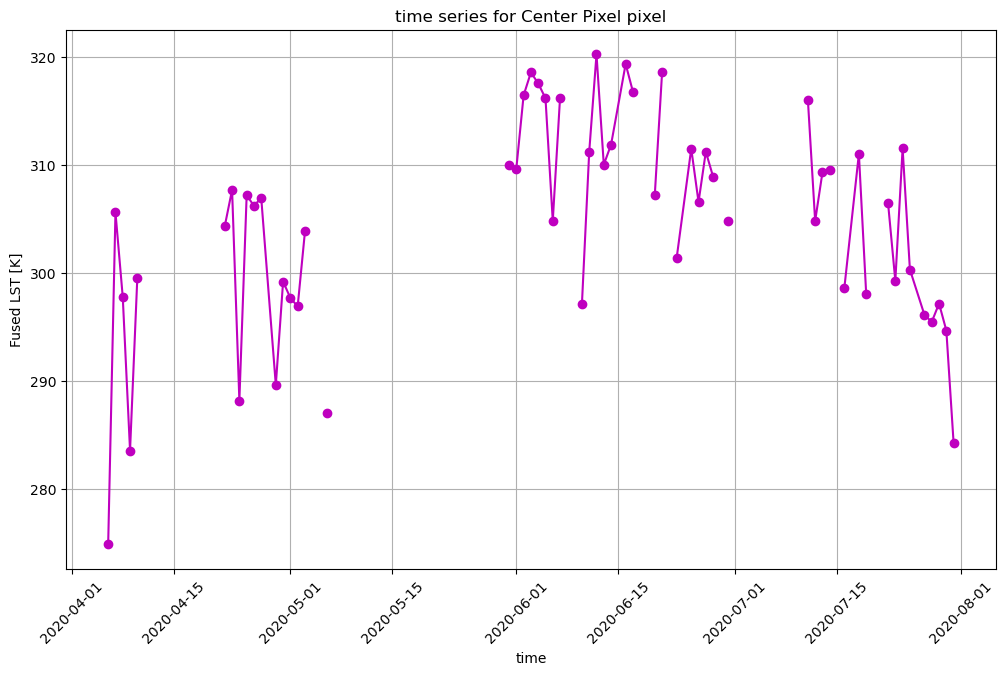

In [173]:
# Get the coords for the center of the tile polygon.
centroid = clip_poly_df.geometry[0].centroid
set_x, set_y, pixtype = (centroid.x, centroid.y, 'Center Pixel') 

# Plot the LST images on a facetgrid. ---------------

# Plot the LST image on col time.
ax = stacked_lst_da.plot(x='x', y='y', col='time', col_wrap=5)
ax.set_xlabels('Easting [m]')
ax.set_ylabels('Northing [m]')

# Plot the point location on each of the LST facetgrid tiles.
ax.map(lambda: plt.plot(set_x, set_y, markersize=20, marker=".", color="m"))
plt.show()
# Save a copy of the figure.
#plt.savefig('multi-image.png', bbox_inches='tight')

# Plot time-series --------------
# Plot the LST time-series from the point location selected from ds_clip.
ax = (stacked_lst_da
      .isel(band=0)
      .sel(x=set_x, y=set_y, method='nearest', tolerance=20)
      .plot(marker='o', c='m', figsize=(12,7))
      )

plt.title(f'time series for {pixtype} pixel')
plt.grid(True)
plt.ylabel('Fused LST [K]')
plt.xticks(rotation=45)
plt.show()
# Save the figure.
#plt.savefig('time-series.png', bbox_inches='tight')

### Plot a time series of the mean LST in the image.
Similarly, we can reduce the area within the subsetting geometry to the mean value, and plot against the time series for the point location.

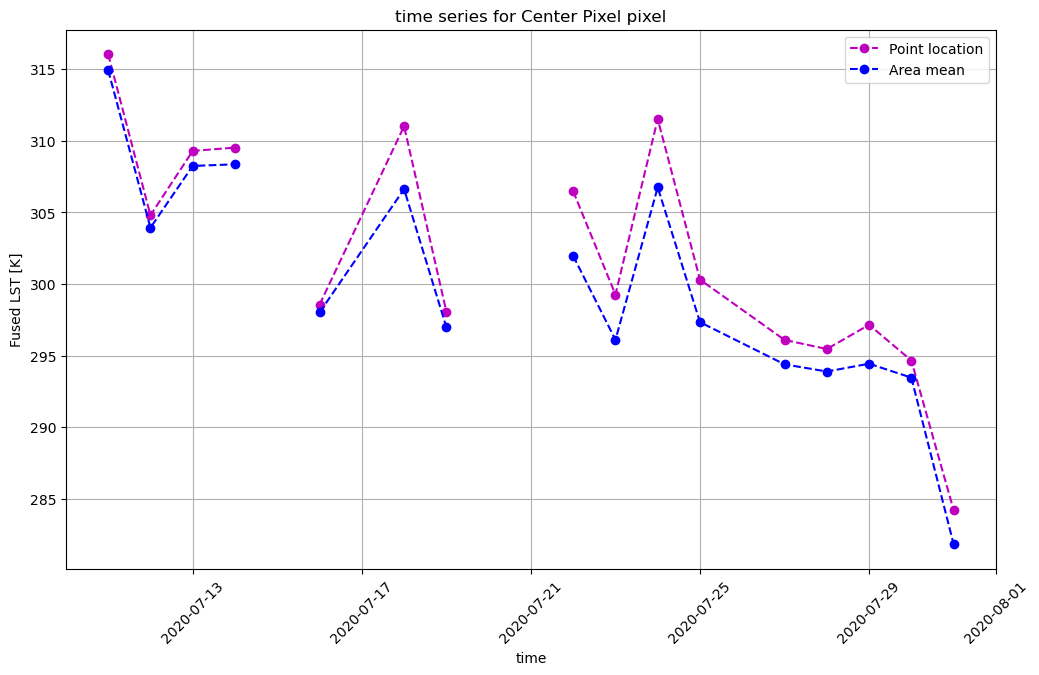

xarray.core.dataarray.DataArray

In [63]:
# Plot two time-series:
#    The LST from the point.  Same as above.
#    The mean LST from the whole image.
ax = (stacked_lst_da
      .isel(band=0)
      .sel(x=set_x, y=set_y, method='nearest', tolerance=20)
      .plot(linestyle='--', marker='o', c='m', label='Point location', figsize=(12,7))
      )

ax = (stacked_lst_da
      .isel(band=0)
      .mean(dim=('x', 'y'))
      .plot(linestyle='--', marker='o', c='b', label='Area mean')
      )

plt.title(f'time series for {pixtype} pixel')
plt.legend()
plt.grid(True)
plt.ylabel('Fused LST [K]')
plt.xticks(rotation=45)
plt.show()

### Drop files with data less than 50% coverage
Sometimes the data will have low coverage due to cloud cover or invalid pixels in the input data products. Let's remove them from the dataset using the `remove_below_data_perc()` function, plot them, and create an animation.

In [174]:
# stacked_lst_da was not created as an object of FH_StackedDataset.
# We'll make it an object here (or try).
LST_filtered_test = FH_StackedDataset(stacked_lst_da)

In [175]:
# to switch back and allow xarray plots
%matplotlib inline 

LST_filtered = FH_StackedDataset(LST_filtered_test.remove_below_data_perc(LST_filtered_test.ds, 0.5))
#ax = LST_filtered.ds.plot(x='x', y='y', col='time', col_wrap=5)
#ax.set_xlabels('Easting [m]')
#ax.set_ylabels('Northing [m]')
#plt.show()

ERROR 1: Request for 63427658-64932787 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 63126903-64624111 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 62208994-63675510 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 62270226-63737830 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 63157223-64654933 failed with response_code=0
ERROR 1: Request for 60428441-61857221 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 346275-352174 failed with response_code=0
ERROR 1: Request for 61533326-6

#### Function for downloading HRRR two meter temperature.

In [178]:
def get_hrrr_point_data(lat, lon, start, days):
    ''' 
    Fetch met data from the HRRR model system.

    Parameters:
    ----------
    lat, lon: float
        Coords from which to pull grid cell data. 
    start: str
        This is the start date for which data will be retrieved.
    days: int
        Number of days of data to retrieve.

    Return:
    -------
    ds_point: xarray dataset
        Met data for specified point.
    '''
    import pandas
    from herbie import FastHerbie

    lat = 42
    lon = -93.7
    sd = "2020-04-01 00:00"

    # Create a range of dates
    DATES = pandas.date_range(
        start=sd,
        periods=91,
        freq="1D",
    )

    # Define forecast lead time (or analysis).
    fxx = range(0, 1)

    # Make FastHerbie Object.
    FH = FastHerbie(DATES, model="hrrr", fxx=fxx)

    # Read a subset of the data with xarray.
    ds = FH.xarray("TMP:2 m", remove_grib=False)

    # Get data values nearest single point
    ds_point = ds.herbie.nearest_points(points=(lon, lat))
    print (ds_point)
    return (ds_point)

#### Get HRRR 2-meter Temperature & create a dataframe for it.

In [179]:
import get_hrrr as hrrr

# Get hrrr data for plotting with lst.
start_date = '2020-04-01 00:00'
temp_2m_ds = get_hrrr_point_data(lat, lon, start_date, 91)

# Convert to dataframe and clean it up.
# Get a dataset of point hrrr and convert to dataframe for easier use.
temp_2m_df = temp_2m_ds.to_dataframe()

# Clean up df and drop uneeded columns.
drop_cols = ['metpy_crs', 'gribfile_projection', 'y', 'x', 'point']
temp_2m_df.reset_index(inplace=True)
temp_2m_df.drop(drop_cols, axis=1, inplace=True)
# Rename some of the cols
temp_2m_df.rename(columns = {'latitude':"hrrr_lat", 'longitude':"hrrr_lon"}, inplace=True)
temp_2m_df.rename(columns = {'point_latitude':"hrrr_pnt_lat", 'point_latitude':"hrrr_pnt_lon"}, inplace=True)
# Make date consistent in format.
temp_2m_df['date'] = pd.to_datetime(temp_2m_df['time'].dt.date)
temp_2m_df

👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/data/hrrr/hrrr/20200401]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/data/hrrr/hrrr/20200402]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/data/hrrr/hrrr/20200403]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/data/hrrr/hrrr/20200404]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/data/hrrr/hrrr/20200405]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/data/hrrr/hrrr/20200406]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/data/hrrr/hrrr/20200407]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/data/hrrr/hrrr/20200408]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/data/hrrr/hrrr/20200409]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/data/hrrr/hrrr/20200410]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/data/hrrr/hrrr/20200411]
👨🏻‍🏭 Creat

,time,step,heightAboveGround,hrrr_lat,hrrr_lon,valid_time,t2m,hrrr_pnt_lon,point_longitude,date
0,2020-04-01,0 days,2.0,41.997852,266.299304,2020-04-01,286.048035,42,-93.7,2020-04-01
1,2020-04-02,0 days,2.0,41.997852,266.299304,2020-04-02,288.403412,42,-93.7,2020-04-02
2,2020-04-03,0 days,2.0,41.997852,266.299304,2020-04-03,286.724854,42,-93.7,2020-04-03
3,2020-04-04,0 days,2.0,41.997852,266.299304,2020-04-04,272.433167,42,-93.7,2020-04-04
4,2020-04-05,0 days,2.0,41.997852,266.299304,2020-04-05,280.873657,42,-93.7,2020-04-05
...,...,...,...,...,...,...,...,...,...,...
86,2020-06-26,0 days,2.0,41.997852,266.299304,2020-06-26,301.928772,42,-93.7,2020-06-26
87,2020-06-27,0 days,2.0,41.997852,266.299304,2020-06-27,301.192719,42,-93.7,2020-06-27
88,2020-06-28,0 days,2.0,41.997852,266.299304,2020-06-28,300.888580,42,-93.7,2020-06-28
89,2020-06-29,0 days,2.0,41.997852,266.299304,2020-06-29,301.160919,42,-93.7,2020-06-29


#### Get LST from centerpoint of AOI & create a dataframe for it. 

In [180]:
# Select lst for a point in the AOI domain.
lst_fil_ds = LST_filtered.ds.isel(band=0).sel(x=set_x, y=set_y, method='nearest', tolerance=20)
# Convert the output to a dataframe.
lst_fil_df = lst_fil_ds.to_dataframe(name='lst')
# Set the index/data to a date format that will be consistent with reindexing below given
# a range of dates.
lst_fil_df.index = pd.to_datetime(lst_fil_df.index).date
# Clean up df and drop uneeded columns.
drop_cols = ['spatial_ref']
lst_fil_df.drop(drop_cols, axis=1, inplace=True)
lst_fil_df.rename(columns = {'x':"x_lst", 'y':"y_lst", 'band':"lst_band"}, inplace=True)

# Fill in any dates where there is missing LST and then reset the index.
# LST sometimes will have days when no data was retrieved.
lst_df = lst_fil_df.reindex(pd.date_range('2020-04-01', '2021-07-31', freq="D")).reset_index()
lst_df

ERROR 1: Request for 61748981-63206279 failed with response_code=0
ERROR 1: Request for 61533326-63001486 failed with response_code=0


,index,lst_band,x_lst,y_lst,lst
0,2020-04-01,NaN,NaN,NaN,NaN
1,2020-04-02,NaN,NaN,NaN,NaN
2,2020-04-03,NaN,NaN,NaN,NaN
3,2020-04-04,NaN,NaN,NaN,NaN
4,2020-04-05,NaN,NaN,NaN,NaN
...,...,...,...,...,...
482,2021-07-27,NaN,NaN,NaN,NaN
483,2021-07-28,NaN,NaN,NaN,NaN
484,2021-07-29,NaN,NaN,NaN,NaN
485,2021-07-30,NaN,NaN,NaN,NaN


#### Merge LST and 2mT dataframes & plot.

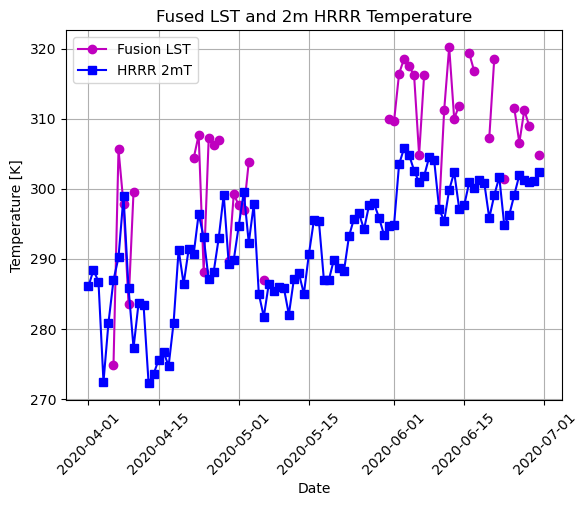

In [181]:
# Merge LST and 2mT dataframes into one larger one.
lst_2mT_df = temp_2m_df.join(lst_df)
# Dont need these two duplicate columns.
lst_2mT_df.drop(['date', 'index'], axis=1, inplace=True)

# Now plot LST and 2mT ----------------------
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['lst'], label='Fusion LST', marker='o', c='m',))# figsize=(12,7)))
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['t2m'], label='HRRR 2mT', marker='s', c='b',))

plt.title(f'Fused LST and 2m HRRR Temperature')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### Calculate CATD and add it to dataframe with LST and 2mT.


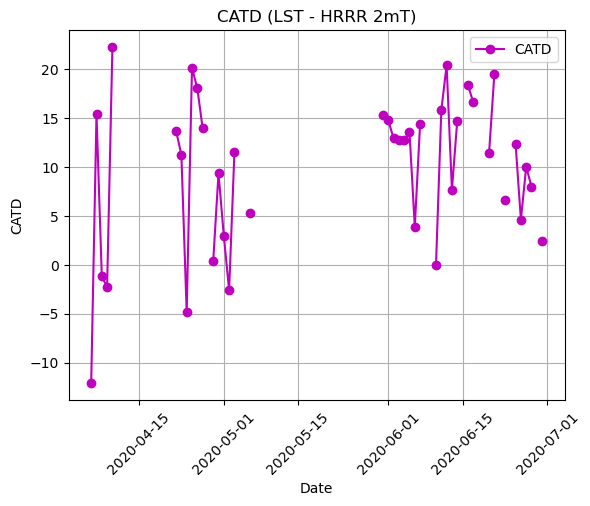

In [182]:
import datetime as dt

# Use the pandas .sub() function to subtract 2mT from LST.
# A fill value can be added for dates where LST is not available.
lst_2mT_df['catd'] = lst_2mT_df['lst'].sub(lst_2mT_df['t2m']) #, fill_value=-9999)

# Plot ------------------------
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['catd'], label='CATD', marker='o', c='m',))

plt.title('CATD (LST - HRRR 2mT)')
plt.grid(True)
plt.ylabel('CATD')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()